In [1]:
import sys
sys.path.append("../src")

from data_loader import WildFireDataLoader
from model_loader import ModelLoader
from evaluator import ModelEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

Загрузка данных:

In [2]:
data_loader = WildFireDataLoader("../data/raw_orig")
data_dict = data_loader.load_all_data()
train_df = data_dict["train"]
test_df = data_dict["test"]

print(f"Тренировочные данные: {len(train_df)}")
print(f"Тестовые данные: {len(test_df)}")
print("\nРаспределение классов в тестовых данных:")
print(test_df['class_name'].value_counts())


INFO:data_loader:Загрузка данных...
INFO:data_loader:Поиск данных в: ../data/raw_orig
INFO:data_loader:Структура: {'train_exists': True, 'test_exists': True, 'train_subfolders': ['Fire', 'Non_Fire'], 'test_subfolders': ['Fire', 'Non_Fire'], 'image_formats': {<built-in method lower of str object at 0x745ebcb8f000>, <built-in method lower of str object at 0x745ebcb8f030>, <built-in method lower of str object at 0x745ebcb8df20>, <built-in method lower of str object at 0x745ebcb8df50>, <built-in method lower of str object at 0x745ebcb8dfb0>, <built-in method lower of str object at 0x745ebcb8dfe0>, <built-in method lower of str object at 0x745ebcb8de00>, <built-in method lower of str object at 0x745ebcb8de30>, <built-in method lower of str object at 0x745ebcd73e40>, <built-in method lower of str object at 0x745ebcb8de60>, <built-in method lower of str object at 0x745ebcb8de90>, <built-in method lower of str object at 0x745ebcb8def0>, <built-in method lower of str object at 0x745ebcb8dda0>, 

Тренировочные данные: 5801
Тестовые данные: 1285

Распределение классов в тестовых данных:
class_name
Non_Fire    723
Fire        562
Name: count, dtype: int64


Загрузка моделей:

In [3]:
model_loader = ModelLoader("cuda")
models_dict = model_loader.load_all_models()

INFO:model_loader:Используется устройство: cuda
INFO:model_loader:Загрузка всех моделей...
INFO:model_loader:Загрузка модели: Gurveer05/vit-base-patch16-224-in21k-fire-detection
INFO:model_loader:Модель base успешно загружена. Параметров: 85,800,194
INFO:model_loader:Загрузка модели: EdBianchi/vit-fire-detection
INFO:model_loader:Модель finetuned успешно загружена. Параметров: 85,800,963
INFO:model_loader:Загружено 2 из 2


Оценка:

In [4]:
evaluator = ModelEvaluator(data_loader, model_loader, batch_size = 64)

In [6]:
test_results = {}
for model_key in ['base', 'finetuned']:
    print(f"\nОценка модели: {model_key}")
    metrics = evaluator.evaluate_model(model_key, test_df)
    test_results[model_key] = metrics

    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    print(f"  TP/FP/FN/TN: {metrics['tp']}/{metrics['fp']}/{metrics['fn']}/{metrics['tn']}")

INFO:evaluator:Оценка модели base на 1285 изображениях...



Оценка модели: base


100%|██████████| 21/21 [01:15<00:00,  3.59s/it]
INFO:evaluator:Оценка модели finetuned на 1285 изображениях...


  Accuracy:  0.9790
  Precision: 0.9715
  Recall:    0.9917
  F1-Score:  0.9815
  TP/FP/FN/TN: 717/21/6/541

Оценка модели: finetuned


100%|██████████| 21/21 [01:08<00:00,  3.25s/it]

  Accuracy:  0.9416
  Precision: 0.9332
  Recall:    0.9654
  F1-Score:  0.9490
  TP/FP/FN/TN: 698/50/25/512


Сравнительная таблица:

In [7]:
comparison_df = evaluator.compare_models("test")
print(comparison_df[["model_key", "accuracy", "precision", "recall", "f1"]].to_string())

INFO:evaluator:Сравнение моделей на test...
INFO:evaluator:Оценка модели base на 1285 изображениях...
100%|██████████| 21/21 [01:05<00:00,  3.13s/it]
INFO:evaluator:Оценка модели finetuned на 1285 изображениях...
100%|██████████| 21/21 [01:06<00:00,  3.18s/it]

   model_key  accuracy  precision    recall        f1
0       base  0.978988   0.971545  0.991701  0.981520
1  finetuned  0.941634   0.933155  0.965422  0.949014


Визуализация:

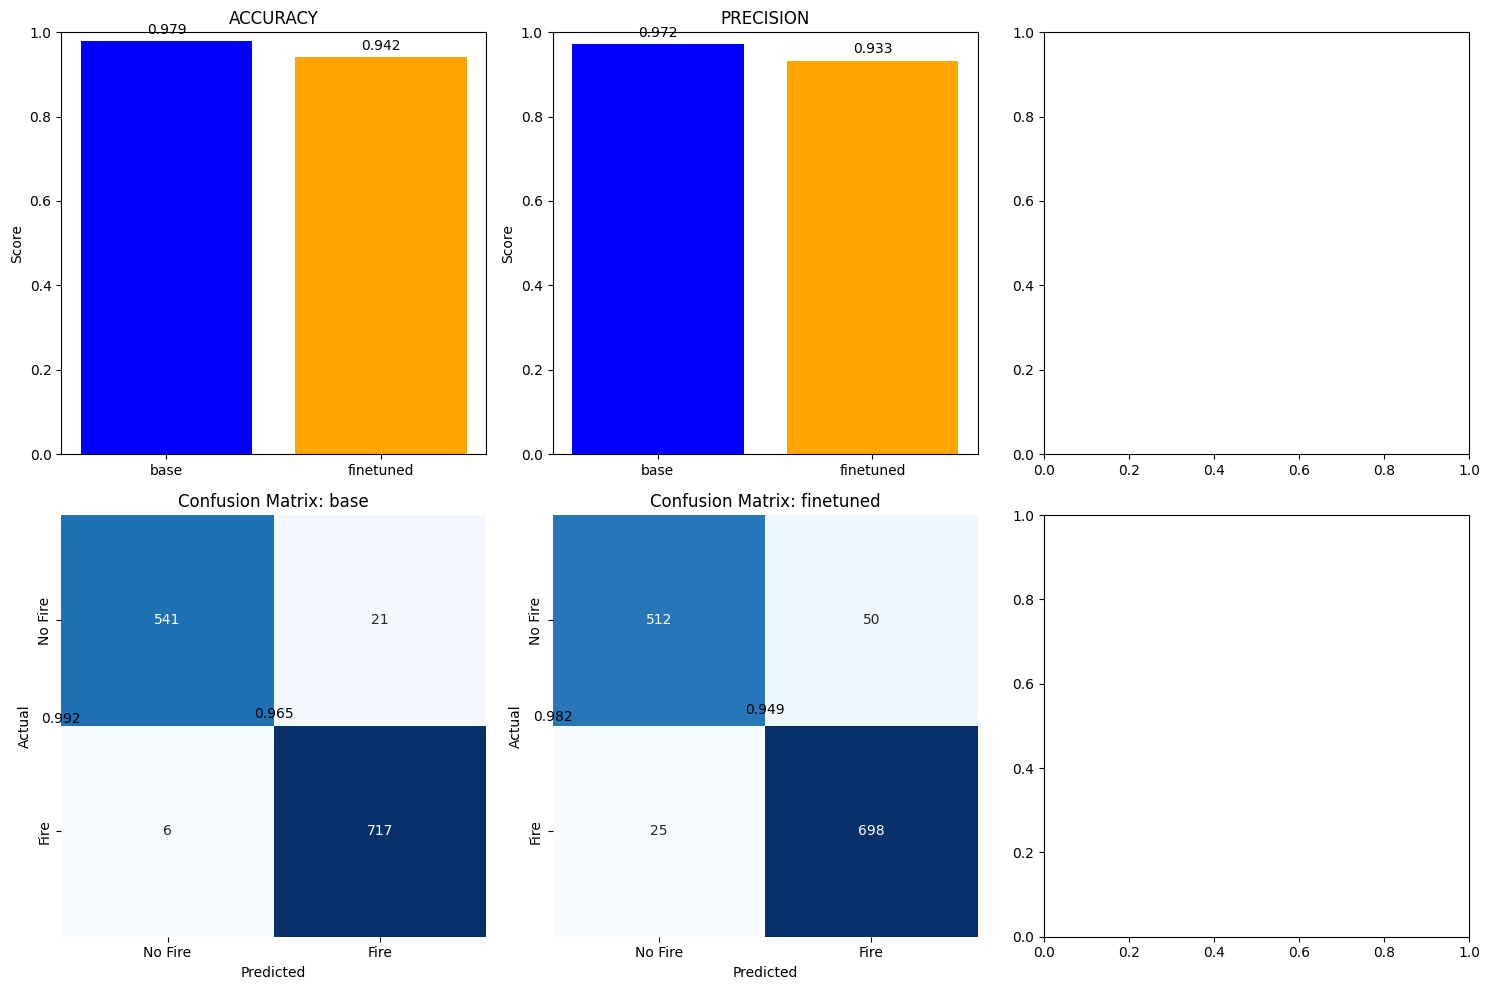

In [8]:
evaluator.plot_comparison(comparison_df, save_path='../outputs/figures/model_comparison.png')

Анализ ошибок:


Неправильные предсказания для base:


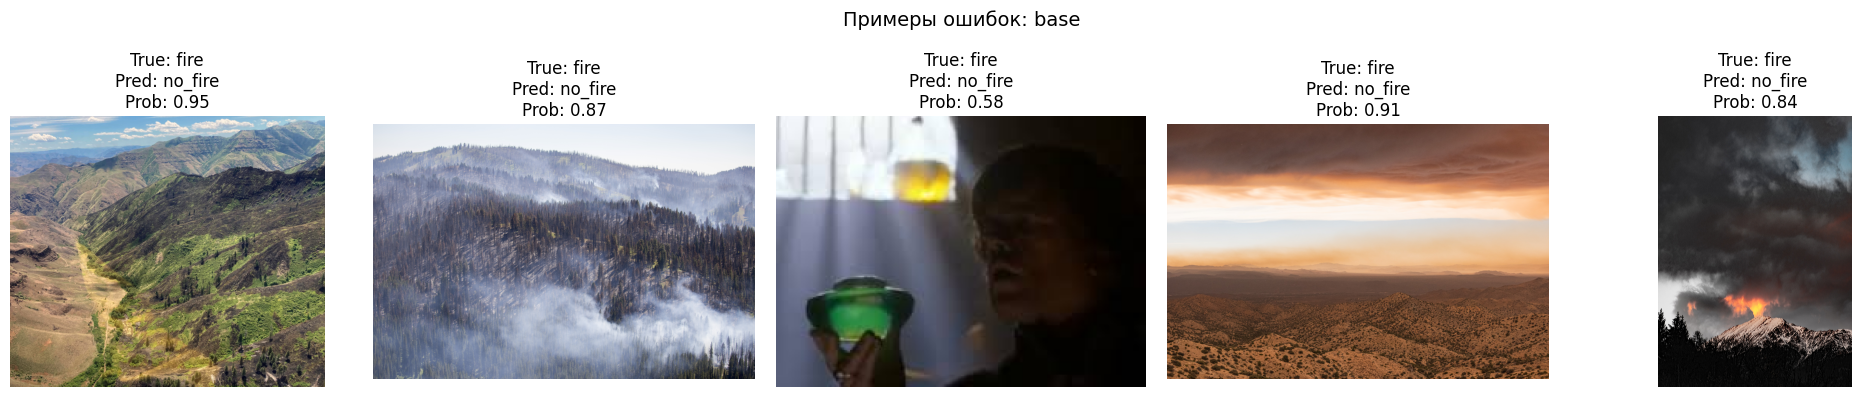

  Всего ошибок: 27

Неправильные предсказания для finetuned:


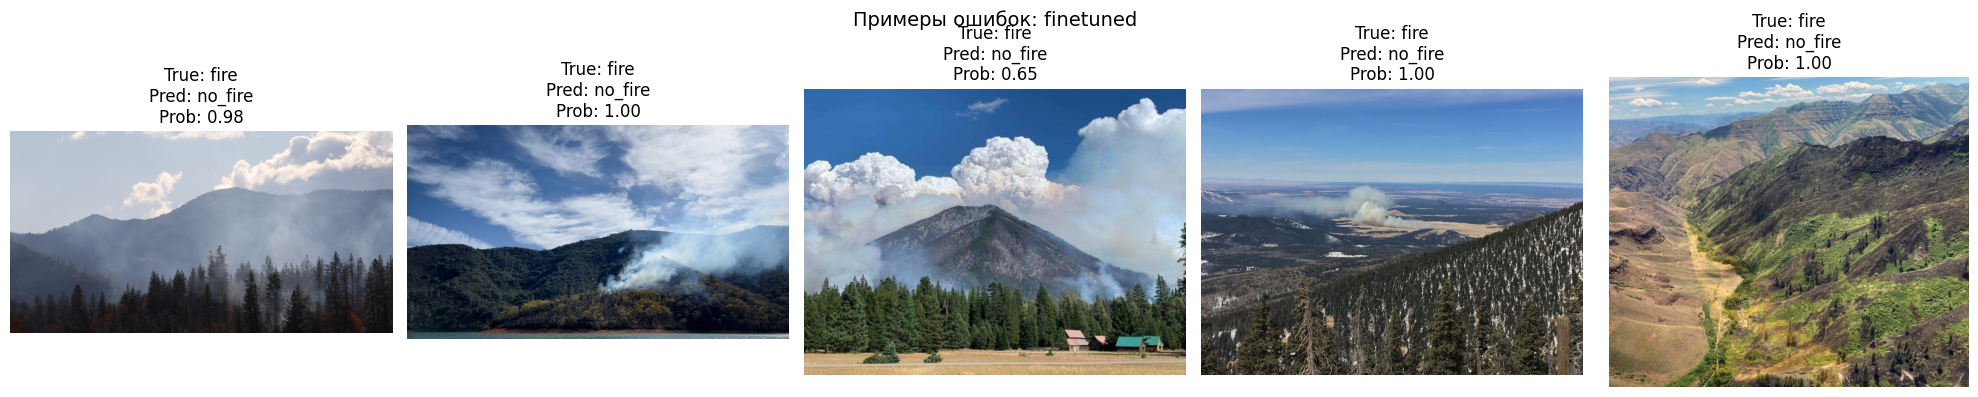

  Всего ошибок: 75


In [9]:
for model_key in ['base', 'finetuned']:
    print(f"\nНеправильные предсказания для {model_key}:")
    misclassified = evaluator.get_misclassified_examples(model_key, n_examples=5)
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for idx, example in enumerate(misclassified):
        from PIL import Image
        img = Image.open(example['image_path'])
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {example['true_class']}\nPred: {example['predicted_class']}\nProb: {example['probability']:.2f}")
        axes[idx].axis('off')
    
    plt.suptitle(f"Примеры ошибок: {model_key}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f'../outputs/figures/misclassified_{model_key}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  Всего ошибок: {len(evaluator.results[model_key]['predictions']) - evaluator.results[model_key]['metrics']['tp'] - evaluator.results[model_key]['metrics']['tn']}")


Сохранение результатов:

In [ ]:
from utils import save_json_with_numpy

os.makedirs('../outputs/reports', exist_ok=True)
save_json_with_numpy({
    'base': evaluator.results['base']['metrics'],
    'finetuned': evaluator.results['finetuned']['metrics']
}, '../outputs/reports/model_comparison.json')
comparison_df.to_csv('../outputs/reports/comparison_table.csv', index=False)


TypeError: Object of type ndarray is not JSON serializable